
# Advanced Sounding

Plot a sounding using MetPy with more advanced features. This will use the same formatting and another dataset from MetPy's sample data.<br>
> New additions
> - Lifted condensation level calculation (LCL)
> - Surface based parcel profile 
> - Convective Available Potential Energy (CAPE) and Convective Inhibition (CIN) shaded
> - 0 degree isotherm distinguished


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

## Obtain Data and Format

Upper air data can be obtained using the siphon package, but for this example we will use some of MetPy's sample data.
`as_file_obj=False), skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)` is necessary due to the formatting of the MetPy sample data. This formatting is not needed when using upper air data obtained via Siphon. Obtaining data with Siphon will be covered in a later notebook. 

In [2]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

sounding_data = pd.read_fwf(get_test_data('may4_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all not a number (NaN) values for temperature, dewpoint, and winds
sounding_data = sounding_data.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

## Assign Units

We will pull the data out of the example dataset into individual variables and assign units. This is explained in further detail in the Simple Sounding notebook and in the [Metpy documentation](https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html).


In [3]:
pres = sounding_data['pressure'].values * units.hPa
temp = sounding_data['temperature'].values * units.degC
dewpoint = sounding_data['dewpoint'].values * units.degC
wind_speed = sounding_data['speed'].values * units.knots
wind_dir = sounding_data['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

## Create Sounding Plot

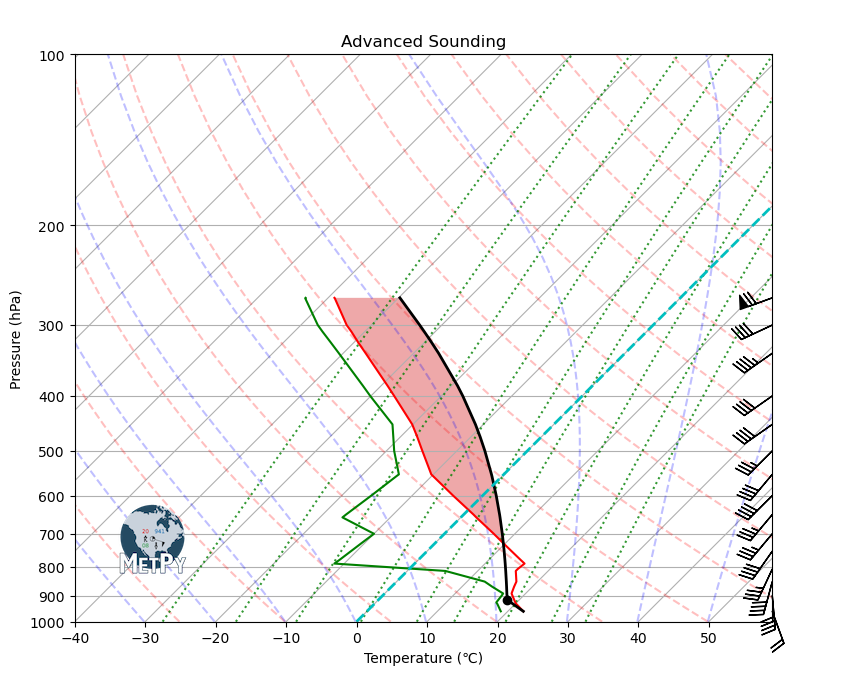

In [4]:
# Create figure and set size
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot temperature, dewpoint and wind barbs
skew.plot(pres, temp, 'red')
skew.plot(pres, dewpoint, 'green')

# Plot wind barbs
my_interval = np.arange(100, 1000, 50) * units('hPa') #set spacing interval
ix = mpcalc.resample_nn_1d(pres, my_interval) #find nearest indices for chosen interval
skew.plot_barbs(pres[ix], u[ix], v[ix], xloc=1) #plot values closest to chosen interval

# Improve labels and set axis limits
skew.ax.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 59)

# Calculate LCL height and plot as black dot.
lcl_pressure, lcl_temperature = mpcalc.lcl(pres[0], temp[0], dewpoint[0]) #index 0 is chosen to lift parcel from the surface
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')
skew.plot(pres, prof, 'black', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(pres, temp, prof, dewpoint)
skew.shade_cape(pres, temp, prof)

# Add emphasis to 0 degree isotherm with color change
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 15) * units.K, alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 10) * units.K, alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -25) * units.hPa, linestyle='dotted', color='tab:blue')

# Add the MetPy logo!
fig = plt.gcf()
add_metpy_logo(fig, 115, 100, size='small');

# Add a title
plt.title('Advanced Sounding');